In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/content/car_sharing.csv')

In [3]:
df.head(3)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350


In [4]:
columns = ['Make','Model','Year','Engine HP','Engine Cylinders','Transmission Type','Vehicle Style','highway MPG','city mpg']
df = df[columns+['MSRP']]

In [5]:
df.columns = df.columns.str.replace(' ', '_').str.lower()

In [6]:
df.rename(columns={'msrp': 'price'}, inplace=True)

In [7]:
categoricas = df.select_dtypes(include=['object']).columns.tolist()
numericas = df.select_dtypes(include=['number']).columns.tolist()

In [8]:
df[categoricas].nunique()

make                  48
model                915
transmission_type      5
vehicle_style         16
dtype: int64

In [9]:
df.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price'],
      dtype='object')

In [10]:
df.isnull().sum()

make                  0
model                 0
year                  0
engine_hp            69
engine_cylinders     30
transmission_type     0
vehicle_style         0
highway_mpg           0
city_mpg              0
price                 0
dtype: int64

In [11]:
df.fillna(0, inplace=True)

Question 1
What is the most frequent observation (mode) for the column transmission_type?

In [12]:
df.transmission_type.value_counts()

AUTOMATIC           8266
MANUAL              2935
AUTOMATED_MANUAL     626
DIRECT_DRIVE          68
UNKNOWN               19
Name: transmission_type, dtype: int64

Question 2
Create the correlation matrix for the numerical features of your dataset. In a correlation matrix, you compute the correlation coefficient between every pair of features in the dataset.

What are the two features that have the biggest correlation in this dataset?

In [13]:
df.corr()

<ipython-input-13-2f6f6606aa2c>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,year,engine_hp,engine_cylinders,highway_mpg,city_mpg,price
year,1.000000,0.338714,-0.040708,0.258240,0.198171,0.227590
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918,0.650095
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306,0.526274
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829,-0.160043
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000,-0.157676
price,0.227590,0.650095,0.526274,-0.160043,-0.157676,1.000000


<ipython-input-14-7046e2aae539>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


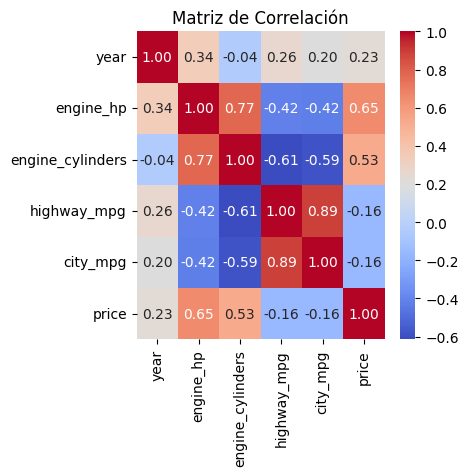

In [14]:
correlation_matrix = df.corr()

# Crea un mapa de calor (heatmap) de la matriz de correlación
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de Correlación')
plt.show()

In [15]:
df['above_average'] = np.where(df.price > df.price.mean(),1,0)

In [16]:
df.price.mean()

40594.737032063116

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

y_train = df_train.above_average
y_val = df_val.above_average

del df_train['price']
del df_val['price']
del df_val['above_average']

In [19]:
df_train.shape[0]/df.shape[0]

0.5999664260533826

In [20]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

Question 3
Calculate the mutual information score between above_average and other categorical variables in our dataset. Use the training set only.
Round the scores to 2 decimals using round(score, 2).
Which of these variables has the lowest mutual information score?

In [21]:
from sklearn.metrics import mutual_info_score

In [22]:
for serie in df_train.columns:
    print(serie, round(mutual_info_score(df_train[serie], df_train.above_average),2))

make 0.24
model 0.46
year 0.07
engine_hp 0.36
engine_cylinders 0.12
transmission_type 0.02
vehicle_style 0.08
highway_mpg 0.04
city_mpg 0.06
above_average 0.59


In [23]:
def calculate_mi(series):
    return mutual_info_score(series, df_train.above_average)

df_mi = df_train.apply(calculate_mi)
df_mi = df_mi.sort_values(ascending=False).to_frame(name='MI')

In [24]:
round(df_mi,2)

,MI
above_average,0.59
model,0.46
engine_hp,0.36
make,0.24
engine_cylinders,0.12
vehicle_style,0.08
year,0.07
city_mpg,0.06
highway_mpg,0.04
transmission_type,0.02


Question 4
Now let's train a logistic regression.
Remember that we have several categorical variables in the dataset. Include them using one-hot encoding.
Fit the model on the training dataset.
To make sure the results are reproducible across different versions of Scikit-Learn, fit the model with these parameters:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
Calculate the accuracy on the validation dataset and round it to 2 decimal digits.
What accuracy did you get?

**Opción 2**

In [25]:
del df_train['above_average']

In [26]:
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
dv.fit(train_dict)

X_train = dv.transform(train_dict)

In [27]:
model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

LogisticRegression(C=10, max_iter=1000, random_state=42, solver='liblinear')

In [28]:
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [29]:
from sklearn.metrics import accuracy_score
acu_ini = round(accuracy_score(y_val, y_pred >= 0.5),2)
acu_ini

0.93

Question 5
Let's find the least useful feature using the feature elimination technique.
Train a model with all these features (using the same parameters as in Q4).
Now exclude each feature from this set and train a model without it. Record the accuracy for each model.
For each feature, calculate the difference between the original accuracy and the accuracy without the feature.

In [30]:
 df_train.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg'],
      dtype='object')

In [31]:
for columna_eliminada in df_train.columns:
    df_train_1 = df_train.drop(columns=columna_eliminada)
    df_val_1 = df_val.drop(columns=columna_eliminada)
    train_dict_1 = df_train_1.to_dict(orient='records')
    dv_1 = DictVectorizer(sparse=False)
    dv_1.fit(train_dict_1)
    X_train_i = dv_1.transform(train_dict_1)
    model_i = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
    model_i.fit(X_train_i, y_train)
    val_dict_i = df_val_1.to_dict(orient='records')
    X_val_i = dv_1.transform(val_dict_i)
    y_pred_i = model_i.predict_proba(X_val_i)[:, 1]
    accu = accuracy_score(y_val, y_pred_i >= 0.5)
    print('La variable es: %5s, la accuracy sin ella es %.2f y su resta %.2f' % (columna_eliminada,accu, acu_ini-accu))

La variable es:  make, la accuracy sin ella es 0.95 y su resta -0.02
La variable es: model, la accuracy sin ella es 0.92 y su resta 0.01
La variable es:  year, la accuracy sin ella es 0.95 y su resta -0.02
La variable es: engine_hp, la accuracy sin ella es 0.93 y su resta -0.00
La variable es: engine_cylinders, la accuracy sin ella es 0.95 y su resta -0.02
La variable es: transmission_type, la accuracy sin ella es 0.95 y su resta -0.02
La variable es: vehicle_style, la accuracy sin ella es 0.93 y su resta -0.00
La variable es: highway_mpg, la accuracy sin ella es 0.95 y su resta -0.02
La variable es: city_mpg, la accuracy sin ella es 0.95 y su resta -0.02


Question 6
For this question, we'll see how to use a linear regression model from Scikit-Learn.
We'll need to use the original column price. Apply the logarithmic transformation to this column.
Fit the Ridge regression model on the training data with a solver 'sag'. Set the seed to 42.
This model also has a parameter alpha. Let's try the following values: [0, 0.01, 0.1, 1, 10].
Round your RMSE scores to 3 decimal digits.
Which of these alphas leads to the best RMSE on the validation set?

In [32]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=42)

y_train = np.log1p(df_train.price)
y_val = np.log1p(df_val.price)

In [33]:
del df_train['price']
del df_val['price']
del df_val['above_average']
del df_train['above_average']

In [34]:
train_dict = df_train.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)
X_train = dv.transform(train_dict)
val_dict = df_val.to_dict(orient='records')
X_val = dv.transform(val_dict)

In [35]:
from sklearn.linear_model import Ridge

In [36]:
def rmse(y, y_pred):
    error = y_pred - y
    mse = (error ** 2).mean()
    return np.sqrt(mse)

In [37]:
alpha =[0, 0.01, 0.1, 1, 10]

for i in alpha:
    model = Ridge(solver='sag', random_state=42, alpha=i, max_iter=1000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    score = round(rmse(y_val, y_pred),3)
    print('alpha %.2f y error %.2f' % (i,score))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha 0.00 y error 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha 0.01 y error 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha 0.10 y error 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


alpha 1.00 y error 0.49
alpha 10.00 y error 0.49


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
